# EQTransformer 1 Day Test

### Using Raspberry Shake earthquake data from 12-29-2022 recorded within a 5° circle around the islands of Hispañola and Puerto Rico.

##### Data was put through the BlocklyEQTransformer machine learning tool to pick out predicted P and S waves. This is set up here along with a  theoretical catalog of events from USGS in order to compare P and S wave arrival times, determining which events were picked up by the machine learning tool versus USGS and vice versa.


In [25]:
from obspy.core.inventory.inventory import read_inventory
from obspy.taup import TauPyModel
from obspy.core.event import read_events
from obspy import read
from obspy.geodetics import  kilometer2degrees as km2deg
import matplotlib.pyplot as plt
import numpy as np
import os
from obspy.taup import TauPyModel
from obspy.taup import plot_travel_times
import pandas as pd 
from obspy.geodetics.base import gps2dist_azimuth as ll2daz
from obspy import UTCDateTime as UTC
import glob
model = TauPyModel(model="iasp91")

In [4]:
#creating events catalog

events = pd.read_csv('https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2022-12-29T00:00:00&endtime=2022-12-30T00:00:00&latitude=17.5&longitude=-70&maxradius=5')

#creating list of stations

inv = pd.read_json('station_list.json').transpose()
inv['stat'] = inv.index
stationslist = []
for index, row in inv.iterrows():
    [lat,lon,depth] = row['coords']
    listadd = (lat,lon,depth,row['stat'])
    stationslist.append(listadd)


In [39]:
events.head

<bound method NDFrame.head of                         time   latitude  longitude   depth   mag magType  nst  \
0   2022-12-29T22:12:33.990Z  18.469100 -68.729000  121.00  4.11      md   25   
1   2022-12-29T21:12:44.670Z  18.015667 -65.386833   18.66  2.51      md    6   
2   2022-12-29T18:34:38.330Z  17.980167 -66.944833    9.73  2.82      md   31   
3   2022-12-29T16:31:11.870Z  17.983000 -66.970333    6.61  1.94      md    8   
4   2022-12-29T14:13:52.330Z  18.003333 -66.844833   13.37  1.98      md    7   
5   2022-12-29T13:59:49.900Z  17.972167 -66.952000    7.68  1.78      md    4   
6   2022-12-29T13:01:34.230Z  17.956667 -66.972667   10.50  2.08      md   13   
7   2022-12-29T12:35:55.480Z  17.996000 -66.833000   11.31  2.00      md    5   
8   2022-12-29T11:23:16.650Z  18.576167 -65.660833   35.36  2.81      md    9   
9   2022-12-29T10:35:40.340Z  17.955167 -66.960167    6.41  2.13      md    7   
10  2022-12-29T05:54:13.400Z  17.955500 -66.821000   10.33  2.10      md    8  

In [36]:
print(stationslist)

[(18.30630631, -66.07594445, 125.0, 'S4051'), (18.01801802, -66.83860199, 34.0, 'R4DB9'), (18.20720721, -73.74886717, 16.0, 'RF6E7'), (18.08108108, -67.04209886, 81.0, 'S897D'), (18.27927928, -66.33100902, 500.0, 'RD66A'), (18.42342342, -73.59426235, 200.0, 'R80C2'), (18.1981982, -71.1000091, 60.0, 'RD4D8'), (19.81981982, -70.72312982, 12.0, 'RA08A'), (18.41441441, -68.93603553, 24.0, 'RE001'), (18.12612613, -67.10740855, 16.0, 'R2974'), (18.45945946, -66.34149666, 6.0, 'R34A9'), (18.20720721, -66.22838073, 210.0, 'RA9CF'), (18.44144144, -66.00258091, 35.0, 'R4802'), (18.38738739, -66.0782667, 14.0, 'R2BF8'), (18.08108108, -67.03136089, 46.0, 'RD17E'), (18.45945946, -67.11405725, 100.0, 'R804D'), (18.5045045, -72.28742153, 574.0, 'R2ABA'), (18.27927928, -73.38986976, 26.0, 'RA7D0'), (18.97297297, -69.03229849, 14.0, 'R54B1'), (18.18018018, -66.30186812, 603.0, 'RF25D'), (18.24324324, -74.08657489, 73.0, 'R16A2'), (19.31531532, -72.1236704, 341.0, 'R595E'), (19.77477477, -72.22637702, 5

In [5]:
#copying stationlist
import shutil
shutil.copy('/home/bmacbeth3/project/BlocklyEQTransformer/scripts/PR_20221229/knownevents/station_list.json', '/home/bmacbeth3/project/BlocklyEQTransformer/scripts/PR_20221229/knownevents/RSML' )

'/home/bmacbeth3/project/BlocklyEQTransformer/scripts/PR_20221229/knownevents/RSML/station_list.json'

In [6]:
#calculating list of THEORETICAL arrival times for P and S waves given regional earthquake locations and origin times
#makes use of Obspy's implementation of the TauP algorithm

phaselist=[]
for station in range(len(stationslist)):
    slat = stationslist[station][0]
    slon = stationslist[station][1]
    stat = stationslist[station][3]
    for each in range(len(events)):
        elat = events.latitude[each]
        elon = events.longitude[each] 
        edep = events.depth[each]
        distazbaz = ll2daz(slat, slon, elat, elon)
        distdeg = km2deg(distazbaz[0]/1000.)
        Parrivals = model.get_travel_times(source_depth_in_km=edep,
                                   distance_in_degree = distdeg,
                                   phase_list=["P","p", "Pn","Pg"])
        Sarrivals = model.get_travel_times(source_depth_in_km=edep,
                                   distance_in_degree = distdeg,
                                   phase_list=["S","s","Sn","Sg"])
        Ps = []
        Ss = []
        for i in range(len(Parrivals)):
            Ps.append(UTC(events.time[each])+Parrivals[i].time)
        for i in range(len(Sarrivals)):
            Ss.append(UTC(events.time[each])+Sarrivals[i].time)
        
        phaselist.append([stat,slat,slon,[elat,elon,edep,UTC(events.time[each])],distdeg,Ps,Ss])

#creating a dataframe for the THEORETICAL arrival times

phasedata = pd.DataFrame(phaselist, columns = ["stat","slat", "slon", "origin", "distdeg", "Ps", "Ss"])
#phasedata.tail()

In [7]:
#creating dataframe of PREDICTED arrival times which were calculated with the BlocklyEQTransformer machine learning tool

DetectDf = pd.DataFrame()

detectdirbase = '/home/bmacbeth3/project/BlocklyEQTransformer/scripts/PR_20221229/detections/'
for path in glob.iglob(detectdirbase + "*_outputs" ): #+ "X_prediction_results.csv"):
    path=str(path+"/X_prediction_results.csv")
    dflocal = pd.read_csv(path, ",")
    DetectDf = DetectDf.append(dflocal, ignore_index = True)
    
DetectDf
#these are the detections based on eqtransformer 

/home/bmacbeth3/anaconda3/envs/bet/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,file_name,network,station,instrument_type,station_lat,station_lon,station_elv,event_start_time,event_end_time,detection_probability,detection_uncertainty,p_arrival_time,p_probability,p_uncertainty,p_snr,s_arrival_time,s_probability,s_uncertainty,s_snr
0,R16A2/AM.R16A2.00.EHZ__20221229T000000Z__20221...,AM,R16A2,EH,18.243243,-74.086575,73.0,2022-12-29 22:44:59.352000,2022-12-29 22:45:11.332000,0.62,NaN,NaN,NaN,NaN,NaN,2022-12-29 22:45:08.102000,0.16,NaN,4.1
1,R16A2/AM.R16A2.00.EHZ__20221229T000000Z__20221...,AM,R16A2,EH,18.243243,-74.086575,73.0,2022-12-29 23:14:43.042000,2022-12-29 23:14:51.552000,0.95,NaN,2022-12-29 23:14:43.102000,0.79,NaN,19.0,2022-12-29 23:14:49.192000,0.26,NaN,4.3
2,R2ABA/AM.R2ABA.00.EHZ__20221229T000000Z__20221...,AM,R2ABA,EH,18.504504,-72.287422,574.0,2022-12-29 18:05:15.964000,2022-12-29 18:05:23.464000,0.46,NaN,2022-12-29 18:05:15.824000,0.47,NaN,16.6,NaN,NaN,NaN,NaN
3,R2ABA/AM.R2ABA.00.EHZ__20221229T000000Z__20221...,AM,R2ABA,EH,18.504504,-72.287422,574.0,2022-12-29 18:05:50.814000,2022-12-29 18:05:59.084000,0.54,NaN,2022-12-29 18:05:51.064000,0.12,NaN,16.6,NaN,NaN,NaN,NaN
4,R2ABA/AM.R2ABA.00.EHZ__20221229T000000Z__20221...,AM,R2ABA,EH,18.504504,-72.287422,574.0,2022-12-29 18:06:35.144000,2022-12-29 18:06:43.264000,0.39,NaN,2022-12-29 18:06:35.114000,0.45,NaN,15.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,R4802/AM.R4802.00.EHZ__20221229T000000Z__20221...,AM,R4802,EH,18.441441,-66.002581,35.0,2022-12-29 10:19:55.287000,2022-12-29 10:20:03.357000,0.63,NaN,2022-12-29 10:19:55.317000,0.28,NaN,7.4,2022-12-29 10:20:01.167000,0.17,NaN,11.0
172,R4802/AM.R4802.00.EHZ__20221229T000000Z__20221...,AM,R4802,EH,18.441441,-66.002581,35.0,2022-12-29 13:47:29.527000,2022-12-29 13:47:58.427000,0.64,NaN,2022-12-29 13:47:29.527000,0.60,NaN,5.1,NaN,NaN,NaN,NaN
173,R4802/AM.R4802.00.EHZ__20221229T000000Z__20221...,AM,R4802,EH,18.441441,-66.002581,35.0,2022-12-29 21:33:37.697000,2022-12-29 21:33:38.107000,0.31,NaN,NaN,NaN,NaN,NaN,2022-12-29 21:33:38.087000,0.11,NaN,10.7
174,RD269/AM.RD269.00.EHZ__20221229T000000Z__20221...,AM,RD269,EH,19.774775,-72.226377,51.0,2022-12-29 04:20:26.646000,2022-12-29 04:21:00.666000,0.88,NaN,2022-12-29 04:20:27.096000,0.12,NaN,0.1,2022-12-29 04:20:50.816000,0.15,NaN,1.7


In [8]:
#saving dataframe locally for others to use
DetectDf.to_pickle("DetectDf.pkl")

In [9]:
phasedata
#these are the predicted phases based on the origin and station location

,stat,slat,slon,origin,distdeg,Ps,Ss
0,S4051,18.306306,-66.075944,"[18.4691, -68.729, 121.0, 2022-12-29T22:12:33....",2.526439,[2022-12-29T22:13:14.133218Z],[2022-12-29T22:13:45.454833Z]
1,S4051,18.306306,-66.075944,"[18.0156666666667, -65.3868333333333, 18.66, 2...",0.716710,"[2022-12-29T21:12:58.562695Z, 2022-12-29T21:12...","[2022-12-29T21:13:08.692318Z, 2022-12-29T21:13..."
2,S4051,18.306306,-66.075944,"[17.9801666666667, -66.9448333333333, 9.73, 20...",0.888323,"[2022-12-29T18:34:55.429845Z, 2022-12-29T18:34...","[2022-12-29T18:35:07.847570Z, 2022-12-29T18:35..."
3,S4051,18.306306,-66.075944,"[17.983, -66.9703333333333, 6.61, 2022-12-29T1...",0.909947,"[2022-12-29T16:31:29.343067Z, 2022-12-29T16:31...","[2022-12-29T16:31:42.031842Z, 2022-12-29T16:31..."
4,S4051,18.306306,-66.075944,"[18.0033333333333, -66.8448333333333, 13.37, 2...",0.791381,"[2022-12-29T14:14:07.660330Z, 2022-12-29T14:14...","[2022-12-29T14:14:18.792946Z, 2022-12-29T14:14..."
...,...,...,...,...,...,...,...
535,R50D4,18.225225,-73.612821,"[17.9615, -66.9686666666667, 13.16, 2022-12-29...",6.329826,"[2022-12-29T03:20:49.422993Z, 2022-12-29T03:20...","[2022-12-29T03:22:02.587244Z, 2022-12-29T03:22..."
536,R50D4,18.225225,-73.612821,"[17.9388333333333, -66.9081666666667, 11.51, 2...",6.388734,"[2022-12-29T03:17:30.950108Z, 2022-12-29T03:17...","[2022-12-29T03:18:44.887090Z, 2022-12-29T03:18..."
537,R50D4,18.225225,-73.612821,"[17.95, -66.9675, 10.56, 2022-12-29T02:01:00.8...",6.331626,"[2022-12-29T02:02:34.159868Z, 2022-12-29T02:02...","[2022-12-29T02:03:47.546178Z, 2022-12-29T02:03..."
538,R50D4,18.225225,-73.612821,"[18.0535, -67.113, 20.44, 2022-12-29T01:46:48....",6.187757,"[2022-12-29T01:48:18.481131Z, 2022-12-29T01:48...","[2022-12-29T01:49:29.535139Z, 2022-12-29T01:49..."


In [10]:
theorPhase=phasedata.copy()
tbuf=30
# add column to theoretical detection DF
theorPhase["EQTdetect"]=np.nan
for idTher in theorPhase.index: # each row contains a unique theoretical prediction based on catalog seismicity
    PsTher=theorPhase["Ps"][idTher]
    stat=theorPhase["stat"][idTher]
    for idDet in DetectDf[DetectDf["station"]==stat].index:
        if DetectDf["p_arrival_time"][idDet] is not np.nan:  # only when not NaN
            PPred=UTC(DetectDf["p_arrival_time"][idDet])
            if PPred >= UTC(min(PsTher)-tbuf) and PPred <= UTC(max(PsTher)+tbuf):
                theorPhase["EQTdetect"][idTher]=idDet 
                #fills the EQTdetect column with the index of the station in DetectDf
                #which has an event which fits within these parameters
        
                

/home/bmacbeth3/anaconda3/envs/bet/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [11]:
detPhase=phasedata.copy()
tbuf=30
# add column to theoretical detection DF
theorPhase["EQTdetect"]=np.nan
for idTher in theorPhase.index: # each row contains a unique theoretical prediction based on catalog seismicity
    PsTher=theorPhase["Ps"][idTher]
    stat=theorPhase["stat"][idTher]
    for idDet in DetectDf[DetectDf["station"]==stat].index:
        if DetectDf["p_arrival_time"][idDet] is not np.nan:  # only when not NaN
            PPred=UTC(DetectDf["p_arrival_time"][idDet])
            if PPred >= UTC(min(PsTher)-tbuf) and PPred <= UTC(max(PsTher)+tbuf):
                theorPhase["EQTdetect"][idTher]=idDet 
                #fills the EQTdetect column with the index of the station in DetectDf
                #which has an event which fits within these parameters
        

/home/bmacbeth3/anaconda3/envs/bet/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [12]:
#these are the events which EQTransformer picked AND really happened
theoretical = theorPhase[theorPhase["EQTdetect"]>0]
detectedTheor=len(theoretical)
nondetectedTheor=len(theorPhase)-detectedTheor

print(detectedTheor,nondetectedTheor)
#len()
#theoretical

24 516


In [13]:
theorPhase.head()

,stat,slat,slon,origin,distdeg,Ps,Ss,EQTdetect
0,S4051,18.306306,-66.075944,"[18.4691, -68.729, 121.0, 2022-12-29T22:12:33....",2.526439,[2022-12-29T22:13:14.133218Z],[2022-12-29T22:13:45.454833Z],NaN
1,S4051,18.306306,-66.075944,"[18.0156666666667, -65.3868333333333, 18.66, 2...",0.716710,"[2022-12-29T21:12:58.562695Z, 2022-12-29T21:12...","[2022-12-29T21:13:08.692318Z, 2022-12-29T21:13...",NaN
2,S4051,18.306306,-66.075944,"[17.9801666666667, -66.9448333333333, 9.73, 20...",0.888323,"[2022-12-29T18:34:55.429845Z, 2022-12-29T18:34...","[2022-12-29T18:35:07.847570Z, 2022-12-29T18:35...",NaN
3,S4051,18.306306,-66.075944,"[17.983, -66.9703333333333, 6.61, 2022-12-29T1...",0.909947,"[2022-12-29T16:31:29.343067Z, 2022-12-29T16:31...","[2022-12-29T16:31:42.031842Z, 2022-12-29T16:31...",NaN
4,S4051,18.306306,-66.075944,"[18.0033333333333, -66.8448333333333, 13.37, 2...",0.791381,"[2022-12-29T14:14:07.660330Z, 2022-12-29T14:14...","[2022-12-29T14:14:18.792946Z, 2022-12-29T14:14...",NaN


In [14]:
theoretical.head()

,stat,slat,slon,origin,distdeg,Ps,Ss,EQTdetect
17,S4051,18.306306,-66.075944,"[17.95, -66.9675, 10.56, 2022-12-29T02:01:00.8...",0.919661,"[2022-12-29T02:01:18.570347Z, 2022-12-29T02:01...","[2022-12-29T02:01:31.431460Z, 2022-12-29T02:01...",92.0
20,R4DB9,18.018018,-66.838602,"[18.4691, -68.729, 121.0, 2022-12-29T22:12:33....",1.853180,[2022-12-29T22:13:05.662911Z],[2022-12-29T22:13:30.291215Z],89.0
22,R4DB9,18.018018,-66.838602,"[17.9801666666667, -66.9448333333333, 9.73, 20...",0.107965,[2022-12-29T18:34:40.993094Z],[2022-12-29T18:34:42.927052Z],88.0
31,R4DB9,18.018018,-66.838602,"[17.9813333333333, -66.8546666666667, 13.11, 2...",0.039591,[2022-12-29T05:47:50.504132Z],[2022-12-29T05:47:52.235465Z],79.0
34,R4DB9,18.018018,-66.838602,"[18.2076666666667, -67.1275, 24.15, 2022-12-29...",0.333539,[2022-12-29T03:29:15.329029Z],[2022-12-29T03:29:20.757035Z],78.0


In [15]:
from numpy import isnan

In [16]:
detPhase = DetectDf.copy()
theorPhase = phasedata.copy()
tbuf = 30
detPhase["Detected"] = np.nan
for idDet in detPhase.index:
    PsDet = detPhase["p_arrival_time"][idDet]
    #print(PsDet,type(PsDet))
    if isinstance(PsDet, float) and isnan(PsDet):
        continue
    stat = detPhase["station"][idDet]
    #print(stat, theorPhase["stat"][0])
    for idTher in theorPhase[theorPhase["stat"]==stat].index:
        print(idTher)
        if theorPhase["Ps"][idTher] is not np.nan:
            PsDet = UTC(PsDet)
            PPred = UTC(theorPhase["Ps"][idTher][0])  # only use the first theoretical P prediction
            if PPred >= UTC((PsDet)-tbuf) and PPred <= UTC((PsDet)+tbuf): #no mins or max needed
                 detPhase["Detected"][idDet] = idTher

400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
200
201
202
203
204
205
206
207
208
209


/home/bmacbeth3/anaconda3/envs/bet/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
520
521
522
523
524
525
526
527
528
529
530

In [17]:
#these are the events which really happened AND were picked by EQTransformer
detected = detPhase[detPhase["Detected"]>0]
len(detPhase[detPhase["Detected"]>0])
#print(detected["Detected"])

24

In [18]:
detected["Detected"]
#for example, 5 = 160

5      160.0
6      214.0
13     202.0
28     266.0
36     294.0
38     286.0
40     282.0
61     280.0
78      34.0
79      31.0
88      22.0
89      20.0
91      17.0
92      17.0
101    194.0
102    182.0
103    180.0
109    371.0
119    360.0
134    314.0
135    302.0
138    300.0
143    533.0
174    453.0
Name: Detected, dtype: float64

In [19]:
theoretical["EQTdetect"]
#and here, 160 = 5

17      92.0
20      89.0
22      88.0
31      79.0
34      78.0
160      5.0
180    103.0
182    102.0
194    101.0
202     13.0
214      6.0
266     28.0
280     61.0
282     40.0
286     38.0
294     36.0
300    138.0
302    135.0
314    134.0
360    119.0
371    109.0
375    105.0
453    174.0
533    143.0
Name: EQTdetect, dtype: float64

In [20]:
print("The number of events which really happened AND were picked by EQTransformer:", len(detected)) 
print("The number of events which were picked by EQTransformer AND really happened:", len(theoretical))
print("The total number of events detected:", len(detected) + len(theoretical))

The number of events which really happened AND were picked by EQTransformer: 24
The number of events which were picked by EQTransformer AND really happened: 24
The total number of events detected: 48


In [26]:
#https://www.w3schools.com/python/python_ml_confusion_matrix.asp
#alternate: https://saturncloud.io/blog/constructing-a-confusion-matrix-from-data-without-scikitlearn/ (TRY THIS ONE)
from sklearn import metrics
actual = numpy.random.binomial(1, 0.9, size = 1000)
predicted = numpy.random.binomial(1, 0.9, size = 1000)
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

NameError: name 'numpy' is not defined

In [109]:
#pull up the waveforms when we have a theoretical arrival
print(actual)

[1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0
 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 

In [131]:
detPhase.head()

,file_name,network,station,instrument_type,station_lat,station_lon,station_elv,event_start_time,event_end_time,detection_probability,detection_uncertainty,p_arrival_time,p_probability,p_uncertainty,p_snr,s_arrival_time,s_probability,s_uncertainty,s_snr,Detected
0,R16A2/AM.R16A2.00.EHZ__20221229T000000Z__20221...,AM,R16A2,EH,18.243243,-74.086575,73.0,2022-12-29 22:44:59.352000,2022-12-29 22:45:11.332000,0.62,NaN,NaN,NaN,NaN,NaN,2022-12-29 22:45:08.102000,0.16,NaN,4.1,NaN
1,R16A2/AM.R16A2.00.EHZ__20221229T000000Z__20221...,AM,R16A2,EH,18.243243,-74.086575,73.0,2022-12-29 23:14:43.042000,2022-12-29 23:14:51.552000,0.95,NaN,2022-12-29 23:14:43.102000,0.79,NaN,19.0,2022-12-29 23:14:49.192000,0.26,NaN,4.3,NaN
2,R2ABA/AM.R2ABA.00.EHZ__20221229T000000Z__20221...,AM,R2ABA,EH,18.504504,-72.287422,574.0,2022-12-29 18:05:15.964000,2022-12-29 18:05:23.464000,0.46,NaN,2022-12-29 18:05:15.824000,0.47,NaN,16.6,NaN,NaN,NaN,NaN,NaN
3,R2ABA/AM.R2ABA.00.EHZ__20221229T000000Z__20221...,AM,R2ABA,EH,18.504504,-72.287422,574.0,2022-12-29 18:05:50.814000,2022-12-29 18:05:59.084000,0.54,NaN,2022-12-29 18:05:51.064000,0.12,NaN,16.6,NaN,NaN,NaN,NaN,NaN
4,R2ABA/AM.R2ABA.00.EHZ__20221229T000000Z__20221...,AM,R2ABA,EH,18.504504,-72.287422,574.0,2022-12-29 18:06:35.144000,2022-12-29 18:06:43.264000,0.39,NaN,2022-12-29 18:06:35.114000,0.45,NaN,15.1,NaN,NaN,NaN,NaN,NaN


In [133]:
from obspy.clients.fdsn import Client as fdsnClient
rsclient=fdsnClient("RASPISHAKE")
phaseNum=23
neti='AM'
stati=detPhase["station"][phaseNum]
loci='00'
chani='EHZ'
StartTime=theorPhase["p_arrival_time"][phaseNum][0]-30
EndTime=StartTime+60
stlocal=rsclient.get_waveforms(neti,stati,loci,chani,starttime=StartTime, endtime=EndTime)

KeyError: 'p_arrival_time'

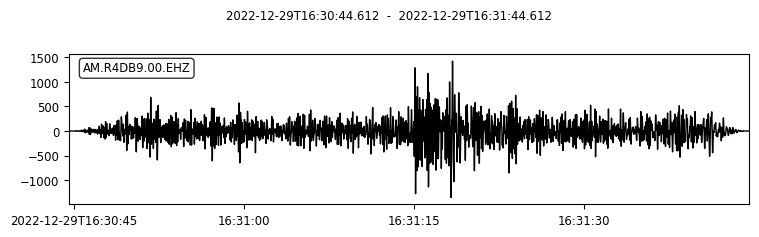

In [121]:
stcopy = stlocal.copy()
stcopy.detrend(type='polynomial', order=5)
stcopy.taper(0.1)
stcopy.filter("bandpass",freqmin = 2, freqmax = 10)
stcopy.plot();

In [122]:
theorPhase["Ps"][23]

[2022-12-29T16:31:14.613093Z]

In [123]:
DetectDf["event_start_time"][79]

'2022-12-29 05:47:50.812000'

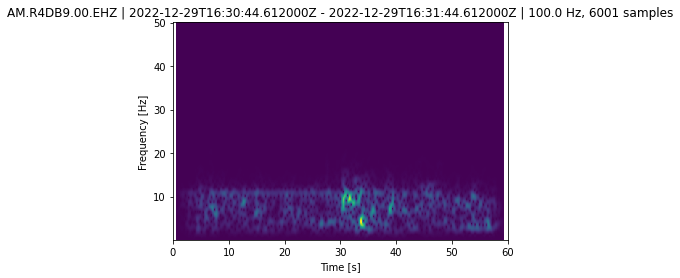

[None]

In [125]:
stcopy.spectrogram()

In [ ]:
#run seisbench on same area, 2021-present, pass everything through bandpass 2-10 hertz

In [351]:
sttestread = read("/home/bmacbeth3/project/BlocklyEQTransformer/seismicdata/PR2021-2023/20210101.mseed")


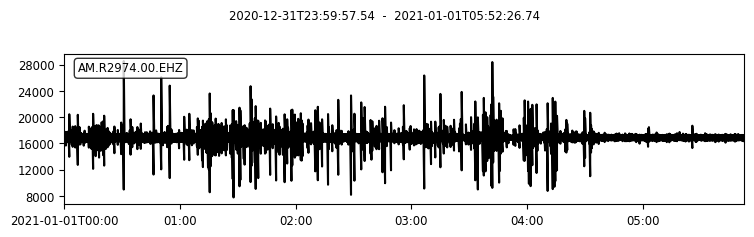

164 Trace(s) in Stream:

AM.R2974.00.EHZ | 2020-12-31T23:59:57.540000Z - 2021-01-01T05:52:26.740000Z | 100.0 Hz, 2114921 samples
...
(162 other traces)
...
AM.S897D.00.EHZ | 2021-01-01T20:06:17.460000Z - 2021-01-02T00:00:01.200000Z | 100.0 Hz, 1402375 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [354]:
sttestread[0].plot();
sttestread.filter("bandpass", freqmin=2, freqmax=10)

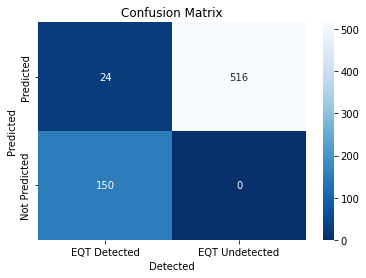

In [143]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Manually specify confusion matrix values
conf_matrix = np.array([[24, 516],
                       [150, 0]])

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
            xticklabels=['EQT Detected', 'EQT Undetected'],
            yticklabels=['Predicted', 'Not Predicted'])
plt.xlabel('Detected')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()